In [14]:
import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

The basic steps we'll take are:

    Use DuckDuckGo to search for images of "bird photos"
    Use DuckDuckGo to search for images of "forest photos"
    Fine-tune a pretrained neural network to recognise these two groups
    Try running this model on a picture of a bird and see if it works.

# Step 1 - preparing the dataset

In [15]:
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai 'duckduckgo_search>=6.2'

In [16]:
from duckduckgo_search import DDGS #DuckDuckGo has changed the api so we need to update 
from fastcore.all import *

def search_images(keywords, max_images=200): return L(DDGS().images(keywords, max_results=max_images)).itemgot('image')
import time, json

In [17]:
#loading the dataset
urls = search_images('car photos', max_images=1)
urls[0]

'https://www.pixelstalk.net/wp-content/uploads/2016/08/Lamborghini-mountain-fog-sports-car-photos.jpg'

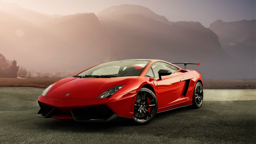

In [18]:
from fastdownload import download_url
dest = 'car.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

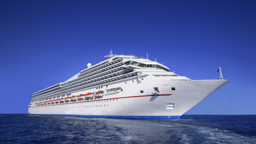

In [19]:
download_url(search_images('ship photos', max_images=1)[0], 'ship.jpg', show_progress=False)
Image.open('ship.jpg').to_thumb(256,256)

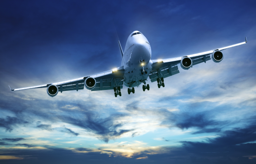

In [20]:
download_url(search_images('airplane photos', max_images=1)[0], 'airplane.jpg', show_progress=False)
Image.open('airplane.jpg').to_thumb(256,256)

In [21]:
searches = 'car','ship','airplane'
path = Path('car_or_ship_or_airplane')

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    time.sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


# Step 2- Train the model

In [22]:
#removing pic that didn't download which may affect our training
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

23

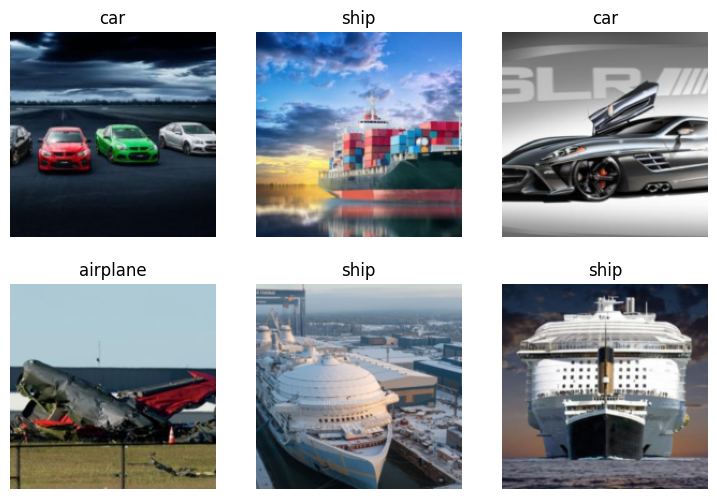

In [27]:
#using dataloaders which is an object that contains our training set and validation set, we can use datablock in fastai to create it
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='crop')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [24]:
#training our data with a fastest widely used computer vision model resnet18 and fastai comes with fine_tune() for fine tunning our model
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.949701,0.055547,0.028571,00:01


epoch,train_loss,valid_loss,error_rate,time
0,0.157211,0.084344,0.028571,00:01
1,0.155830,0.114162,0.038095,00:02
2,0.117005,0.090190,0.038095,00:01
3,0.093391,0.102432,0.038095,00:02


# Step 3- Testing the model

In [26]:
is_car,_,probs = learn.predict(PILImage.create('ship.jpg'))
print(f"This is a: {is_car}.")
print(f"Probability it's a car: {probs[0]:.4f}")

This is a: ship.
Probability it's a car: 0.0000
